In [3]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import json
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
%matplotlib inline
import ast

#import plotly.graph_objs as go 
#from plotly.offline import init_notebook_mode,iplot
#init_notebook_mode(connected=True) 

In [5]:
import os
os.chdir('D:/private/MSTER/big data analysis/the-movies-dataset')

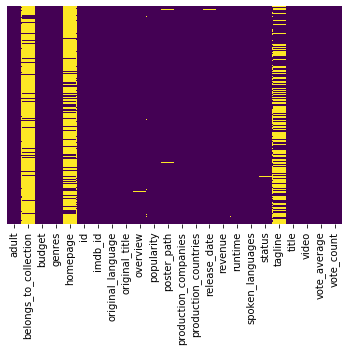

In [17]:
#Read dataset and draw the heatmap to see 
md = pd.read_csv('movies_metadata.csv', low_memory = False)
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
md = md.drop([19730, 29503, 35587])
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
#md.head(2),
#md.info()
sns.heatmap(md.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
md=md.dropna(thresh=5)

In [19]:
#Change the typre from series to int so we can use id to get the small dataset
md['id'] = md['id'].astype('int')
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')

In [20]:
#merge the credits and keywords
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

C:\Users\ruozhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


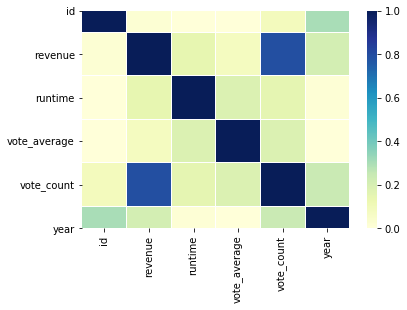

In [21]:
#merge the cast,crew,keywords,year
smd = md[md['id'].isin(links_small)]
smd['year']=pd.to_datetime(smd['release_date']).apply(lambda x: x.year)
#see the correlation between the feature
sns.heatmap(smd.corr(), cmap = 'YlGnBu',vmax=1,vmin=0,linewidth=0.05)

In [22]:
#We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:
    #1.Crew: From the crew, we pick  director,producer as our features.
    #2 Cast: Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 4 actors that appear in the credits list.
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['production_companies'] = smd['production_companies'].apply(literal_eval)
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
def get_producer(x):
    for i in x:
        if i['job'] == 'Producer':
            return i['name']
    return np.nan
smd['director'] = smd['crew'].apply(get_director)
smd['producer'] = smd['crew'].apply(get_producer)

C:\Users\ruozhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ruozhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\ruozhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [26]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['producer'] = smd['producer'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['production_companies'] = [[di['name'] for di in row[0:3]] for row in smd['production_companies']]

C:\Users\ruozhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ruozhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ruozhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [71]:
#We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s[:5]
#Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed. Finally, we will convert every word to its stem so that words such as Dogs and Dog are considered the same.
s = s[s > 1]
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

C:\Users\ruozhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\ruozhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ruozhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [78]:
#Group the year by 10 years
def groupby_year(x):
    if x>1800 and x<=1930:
        return 0
    if x>1930 and x<=1960:
        return 1
    if x>1960 and x<=1980:
        return 2
    if x>1980 and x<=1990:
        return 3
    if x>1990 and x<=2000:
        return 4
    if x>2000 and x<=2010:
        return 5
    if x>2010 and x<=2018:
        return 6

In [79]:
for i in range(9218):
    smd['year'].values[i]=groupby_year(smd['year'].values[i])

In [80]:
smd['production_companies'].head(2)

0                            [Pixar Animation Studios]
1    [TriStar Pictures, Teitler Film, Interscope Co...
Name: production_companies, dtype: object

In [81]:
#Calculate the cosine for each feature we want to include: 
#TfidfVectorizer: overview
smd['overview']=smd['overview'].fillna('')
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix0 = tf.fit_transform(smd['overview'])
# tfidf_matrix.shape
cosine_sim0 = linear_kernel(tfidf_matrix0, tfidf_matrix0)

In [82]:

#Countvector: cast,director,keywords,producer,product_companies
smd['cast']=smd['cast'].astype(str)
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix1 = count.fit_transform(smd['cast'])
cosine_sim1 = cosine_similarity(count_matrix1, count_matrix1)

smd['director']=smd['director'].astype(str)
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix2 = count.fit_transform(smd['director'])
cosine_sim2 = cosine_similarity(count_matrix2, count_matrix2)


smd['producer']=smd['producer'].astype(str)
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix3 = count.fit_transform(smd['cast'])
cosine_sim3 = cosine_similarity(count_matrix3, count_matrix3)

smd['production_companies']=smd['production_companies'].astype(str)
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix4 = count.fit_transform(smd['production_companies'])
cosine_sim4 = cosine_similarity(count_matrix4, count_matrix4)

smd['keywords']=smd['keywords'].astype(str)
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix5 = count.fit_transform(smd['keywords'])
cosine_sim5 = cosine_similarity(count_matrix5, count_matrix5)

In [83]:
#Directorly: Vote_average Vote_count,year
matrix6=np.array([smd['year'].index,smd['year'].values]).T
cosine_sim6 = cosine_similarity(matrix6, matrix6)

matrix7=np.array([smd['vote_count'].index,smd['vote_count'].values]).T
cosine_sim7 = cosine_similarity(matrix7, matrix7)

matrix8=np.array([smd['vote_average'].index,smd['vote_average'].values]).T
cosine_sim8 = cosine_similarity(matrix8, matrix8)

In [84]:
cosine_sim=(cosine_sim0+cosine_sim1+cosine_sim2+cosine_sim3+cosine_sim4+cosine_sim5+cosine_sim6+cosine_sim7+cosine_sim8)/9

In [85]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [86]:
get_recommendations('The Dark Knight').head(10)

6218                         Batman Begins
8031                 The Dark Knight Rises
6623                          The Prestige
7648                             Inception
8613                          Interstellar
3381                               Memento
6521                      Superman Returns
8419                          Man of Steel
9024    Batman v Superman: Dawn of Justice
4145                              Insomnia
Name: title, dtype: object